<a href="https://colab.research.google.com/github/peterruler/malaria-cnn/blob/main/malaria_cnn_pytorch_port.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/peterruler/malaria-cnn/blob/main/malaria-cnn-pytorch-port.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Okay, let's port the Keras malaria detection script to PyTorch. Source: https://www.udemy.com/course/deep-learning-tensorflow/

import os import pandas as pd import numpy as np import seaborn as sns import matplotlib.pyplot as plt from PIL import Image # Using PIL for image loading, common in PyTorch import random import warnings

import torch import torch.nn as nn import torch.optim as optim from torch.utils.data import DataLoader, Dataset from torchvision import datasets, transforms, models # models potentially for transfer learning later from sklearn.metrics import classification_report, confusion_matrix

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image # Using PIL for image loading, common in PyTorch
import random
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models # models potentially for transfer learning later
from sklearn.metrics import classification_report, confusion_matrix

use gpu as computing device if present. use google colab free gpu

In [2]:
# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


try: from google.colab import drive drive.mount('/content/drive') if dir is local use a local dir ./cell_images instead.

In [3]:
# --- Google Drive Mount ---
# (Assuming this is run in Colab or similar environment)
# Keep the Google Drive mounting part as it is, if needed.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Define the data directory (ADJUST THIS PATH IF NEEDED)
    my_data_dir = '/content/drive/My Drive/dl-udemy/cell_images'
except ModuleNotFoundError:
    print("Google Drive mounting skipped (not in Colab env). Assuming data is local.")
    # --- ADJUST THIS PATH if running locally ---
    # Example local path:
    # my_data_dir = 'path/to/your/cell_images'
    my_data_dir = './cell_images' # Default if not in Colab

# Check if the directory exists
if not os.path.exists(my_data_dir):
    print(f"Error: Directory '{my_data_dir}' not found. Please check the path.")
    exit() # Exit if data directory is not found
else:
    print(f"Data directory found: {my_data_dir}")

# Define train and test paths
train_path = os.path.join(my_data_dir, 'train')
test_path = os.path.join(my_data_dir, 'test')

# --- Basic Data Exploration (Optional - similar to Keras version) ---
print("\n--- Data Exploration ---")
print("Listing Train Path Contents:", os.listdir(train_path))
print("Listing Test Path Contents:", os.listdir(test_path))

Mounted at /content/drive
Data directory found: /content/drive/My Drive/dl-udemy/cell_images

--- Data Exploration ---
Listing Train Path Contents: ['parasitized', 'uninfected']
Listing Test Path Contents: ['uninfected', 'parasitized']


Basic Data Exploration (Optional - similar to Keras version)

In [4]:
# Example: View a sample image
try:
    para_cell_path = os.path.join(train_path, 'parasitized', os.listdir(os.path.join(train_path, 'parasitized'))[0])
    para_img_pil = Image.open(para_cell_path)
    print("Sample parasitized image shape (PIL):", para_img_pil.size, para_img_pil.mode)
    # plt.imshow(para_img_pil)
    # plt.title("Sample Parasitized Cell")
    # plt.show()

    uninfected_cell_path = os.path.join(train_path, 'uninfected', os.listdir(os.path.join(train_path, 'uninfected'))[0])
    uninfected_img_pil = Image.open(uninfected_cell_path)
    print("Sample uninfected image shape (PIL):", uninfected_img_pil.size, uninfected_img_pil.mode)
    # plt.imshow(uninfected_img_pil)
    # plt.title("Sample Uninfected Cell")
    # plt.show()

    print("Number of parasitized train images:", len(os.listdir(os.path.join(train_path, 'parasitized'))))
    print("Number of uninfected train images:", len(os.listdir(os.path.join(train_path, 'uninfected'))))
except Exception as e:
    print(f"Could not perform sample image loading/display: {e}")

Sample parasitized image shape (PIL): (124, 142) RGB
Sample uninfected image shape (PIL): (133, 139) RGB
Number of parasitized train images: 12480
Number of uninfected train images: 12490


set the needed (other & hyper-) parameters



In [5]:
# --- Parameters and Image Transformations ---
print("\n--- Setup Parameters and Transformations ---")
IMAGE_HEIGHT = 130
IMAGE_WIDTH = 130
# Note: PyTorch uses Channels First (C, H, W) by default
image_shape_pytorch = (3, IMAGE_HEIGHT, IMAGE_WIDTH) # Channels first
input_shape_conv = (3, IMAGE_HEIGHT, IMAGE_WIDTH) # For Conv2D input

BATCH_SIZE = 16
EPOCHS = 20 # Keras code used 20
LEARNING_RATE = 0.001 # Adam default in Keras is 0.001
PATIENCE = 2 # For early stopping


--- Setup Parameters and Transformations ---


image augmentation

In [6]:
# PyTorch equivalent of ImageDataGenerator augmentation
# Normalize using 1/255 like Keras rescale
# For more standard normalization, use:
# transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10, scale=(0.9, 1.1)), # Combines shift, shear, zoom
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Converts PIL image (H, W, C) to tensor (C, H, W) and scales pixels to [0, 1]
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Alternative: Normalize to [-1, 1]
])

# Test set typically has less or no augmentation, just resizing and tensor conversion/normalization
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(), # Converts PIL image to tensor and scales pixels to [0, 1]
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Match training normalization if used
])

# --- Datasets and DataLoaders ---
# Use ImageFolder - it automatically finds classes based on subdirectory names
print("\n--- Creating Datasets and DataLoaders ---")
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # num_workers for parallel loading
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) # No shuffle for test/eval

# Check class indices (should match Keras)
class_names = train_dataset.classes
class_indices = train_dataset.class_to_idx
print("Class Names:", class_names)
print("Class Indices:", class_indices) # Usually {'parasitized': 0, 'uninfected': 1} or vice-versa, check this


--- Creating Datasets and DataLoaders ---
Class Names: ['parasitized', 'uninfected']
Class Indices: {'parasitized': 0, 'uninfected': 1}


define the pytorch CNN Model

In [7]:
# --- Model Definition ---
print("\n--- Defining the PyTorch Model ---")
class SimpleCNN(nn.Module):
    def __init__(self, input_shape):
        super(SimpleCNN, self).__init__()
        C, H, W = input_shape # Channels, Height, Width

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=C, out_channels=32, kernel_size=(3, 3), padding=1), # Added padding=1 to potentially preserve size slightly better, Keras default is 'valid' (no padding)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )

        # Calculate the flattened size dynamically
        # We need to pass a dummy tensor through the conv layers to find the output shape
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape) # Batch size of 1
            dummy_output = self.conv_layers(dummy_input)
            self.flattened_size = int(torch.flatten(dummy_output, 1).shape[1])
            print(f"Flattened size calculated: {self.flattened_size}") # e.g., 64 * (H/8) * (W/8)

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1) # Output is 1 logit for binary classification
            # We will use BCEWithLogitsLoss, so no Sigmoid here
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate the model
model = SimpleCNN(input_shape=input_shape_conv).to(device)
print("\nModel Architecture:")
print(model)
# For a summary similar to Keras, you might need torchsummary
# try:
#     from torchsummary import summary
#     summary(model, input_shape_conv)
# except ImportError:
#     print("torchsummary not found, skipping model summary.")


# --- Loss Function and Optimizer ---
print("\n--- Setting up Loss and Optimizer ---")
# Use BCEWithLogitsLoss for numerical stability (combines Sigmoid + BCELoss)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


--- Defining the PyTorch Model ---
Flattened size calculated: 16384

Model Architecture:
SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

--- Setting up Loss and Optimizer ---


training with early stopping

In [8]:
# --- Training Loop ---
print("\n--- Starting Training ---")
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Reshape labels for BCEWithLogitsLoss [batch_size] -> [batch_size, 1]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0) # Loss for the batch
        predicted = torch.sigmoid(outputs) > 0.5 # Apply sigmoid and threshold for accuracy calculation
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (i + 1) % 100 == 0: # Print progress every 100 batches
             print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)

    # --- Validation Loop ---
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad(): # No need to track gradients during validation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1) # Reshape labels

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

            predicted = torch.sigmoid(outputs) > 0.5 # Apply sigmoid and threshold
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    epoch_val_acc = correct_val / total_val
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_acc)

    print(f'Epoch [{epoch+1}/{EPOCHS}] - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | Val_Loss: {epoch_val_loss:.4f}, Val_Acc: {epoch_val_acc:.4f}')

    # --- Early Stopping Check ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'malaria_detector_pytorch_best.pth')
        print(f'Validation loss decreased ({best_val_loss:.4f}). Saving model...')
    else:
        epochs_no_improve += 1
        print(f'Validation loss did not improve for {epochs_no_improve} epoch(s).')

    if epochs_no_improve >= PATIENCE:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        # torch.save(model.state_dict(), '/content/drive/My Drive/dl-udemy/models/malaria_detector_pytorch_best.pth')
        break

print('Finished Training')


--- Starting Training ---
Epoch [1/20], Step [100/1561], Loss: 0.7111
Epoch [1/20], Step [200/1561], Loss: 0.7058
Epoch [1/20], Step [300/1561], Loss: 0.6956
Epoch [1/20], Step [400/1561], Loss: 0.6970
Epoch [1/20], Step [500/1561], Loss: 0.6299
Epoch [1/20], Step [600/1561], Loss: 0.6181
Epoch [1/20], Step [700/1561], Loss: 0.2230
Epoch [1/20], Step [800/1561], Loss: 0.3349
Epoch [1/20], Step [900/1561], Loss: 0.4767
Epoch [1/20], Step [1000/1561], Loss: 0.4840
Epoch [1/20], Step [1100/1561], Loss: 0.1834
Epoch [1/20], Step [1200/1561], Loss: 0.1201
Epoch [1/20], Step [1300/1561], Loss: 0.7866
Epoch [1/20], Step [1400/1561], Loss: 0.2078
Epoch [1/20], Step [1500/1561], Loss: 0.2838
Epoch [1/20] - Loss: 0.4573, Acc: 0.7729 | Val_Loss: 0.1781, Val_Acc: 0.9423
Validation loss decreased (0.1781). Saving model...
Epoch [2/20], Step [100/1561], Loss: 0.0688
Epoch [2/20], Step [200/1561], Loss: 0.1595
Epoch [2/20], Step [300/1561], Loss: 0.0984
Epoch [2/20], Step [400/1561], Loss: 0.1831
Ep

save the model

In [9]:
# --- Save the final model (optional) ---
# torch.save(model.state_dict(), 'malaria_detector_pytorch_final.pth')

# --- Load the best model for evaluation ---
print("\n--- Loading Best Model for Evaluation ---")
model.load_state_dict(torch.load('malaria_detector_pytorch_best.pth'))
model.to(device) # Ensure model is on the correct device after loading


--- Loading Best Model for Evaluation ---


SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

visualize traning results


--- Evaluating Model on Test Set ---


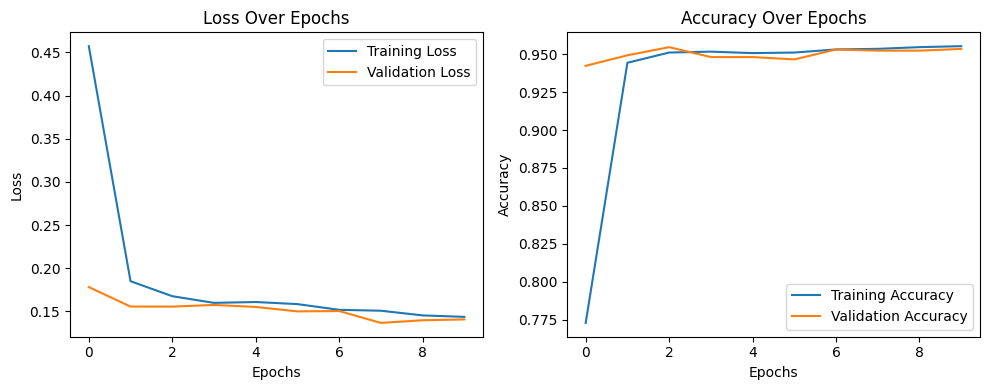

In [10]:
# --- Model Evaluation ---
print("\n--- Evaluating Model on Test Set ---")
losses_df = pd.DataFrame(history)
try:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses_df['loss'], label='Training Loss')
    plt.plot(losses_df['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(losses_df['accuracy'], label='Training Accuracy')
    plt.plot(losses_df['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot history: {e}")

more reports


--- Classification Report ---
              precision    recall  f1-score   support

 parasitized       0.96      0.95      0.95      1300
  uninfected       0.95      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600


--- Confusion Matrix ---
[[1230   70]
 [  54 1246]]


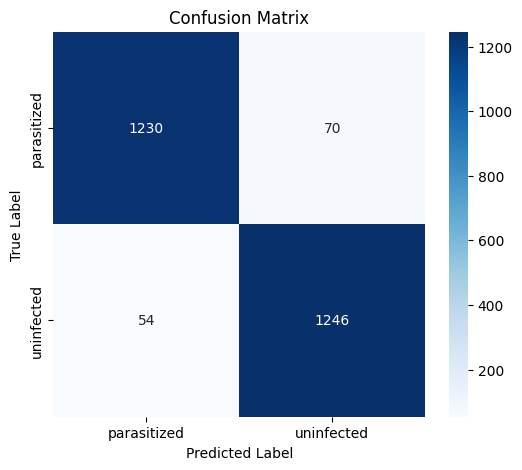

In [11]:
# --- Get Predictions and Evaluate Metrics ---
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        # No need to reshape labels here, keep them as class indices
        labels_np = labels.numpy()
        all_labels.extend(labels_np)

        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy() # Get probabilities
        preds = (probs > 0.5).astype(int).flatten() # Get binary predictions

        all_probs.extend(probs.flatten())
        all_preds.extend(preds)

print("\n--- Classification Report ---")
# Ensure labels used for report match the indices (e.g., 0, 1)
# Check `class_indices` if needed to map back to names
target_names = [name for name, idx in sorted(class_indices.items(), key=lambda item: item[1])] # Get names in order of index
print(classification_report(all_labels, all_preds, target_names=target_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

try:
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
except Exception as e:
    print(f"Could not plot confusion matrix: {e}")

inference single image


--- Predicting Single Image ---
Image: C100P61ThinF_IMG_20150918_144104_cell_162.png
Predicted Probability (positive class): 0.0015
Predicted Class: parasitized


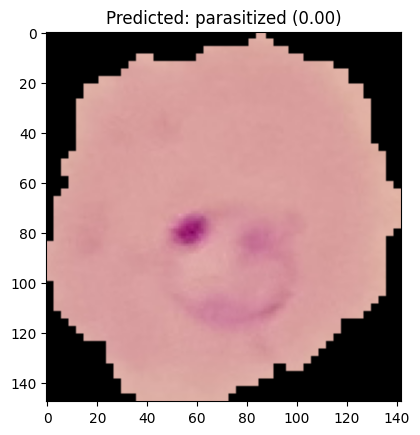

In [12]:
# --- Single Image Prediction Function ---
def predict_single_image(image_path, model, transform, device, class_indices):
    model.eval()
    try:
        image = Image.open(image_path).convert('RGB') # Ensure image is RGB
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None, None

    image_tensor = transform(image).unsqueeze(0).to(device) # Add batch dimension and send to device

    with torch.no_grad():
        output = model(image_tensor)
        probability = torch.sigmoid(output).item() # Get probability for the positive class

    predicted_class_idx = 1 if probability > 0.5 else 0
    # Get class name from index
    predicted_class_name = [name for name, idx in class_indices.items() if idx == predicted_class_idx][0]

    return probability, predicted_class_name

print("\n--- Predicting Single Image ---")
# Use the test transform for single image prediction
single_image_transform = test_transforms

# Example using the same parasitized cell from Keras example
para_cell_path = os.path.join(train_path, 'parasitized', 'C100P61ThinF_IMG_20150918_144104_cell_162.png') # Make sure this exists
prob, pred_class = predict_single_image(para_cell_path, model, single_image_transform, device, class_indices)

if prob is not None:
    print(f"Image: {os.path.basename(para_cell_path)}")
    print(f"Predicted Probability (positive class): {prob:.4f}")
    print(f"Predicted Class: {pred_class}")

    try:
        img_display = Image.open(para_cell_path)
        plt.imshow(img_display)
        plt.title(f"Predicted: {pred_class} ({prob:.2f})")
        plt.show()
    except Exception as e:
        print(f"Could not display image: {e}")

inference two randonmly picked images


--- Predicting Random Test Images ---

Predicting Infected Sample:
Image: C60P21thinF_IMG_20150803_144629_cell_15.png
Actual Class: Infected
Predicted Probability (positive class): 0.0000
Predicted Class: parasitized


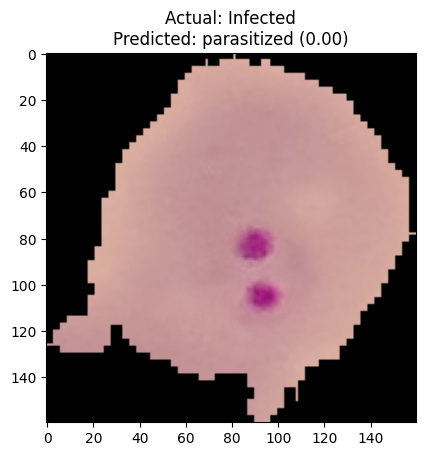


Predicting Uninfected Sample:
Image: C42P5thin_original_IMG_20150623_134426_cell_17.png
Actual Class: Uninfected
Predicted Probability (positive class): 0.9799
Predicted Class: uninfected


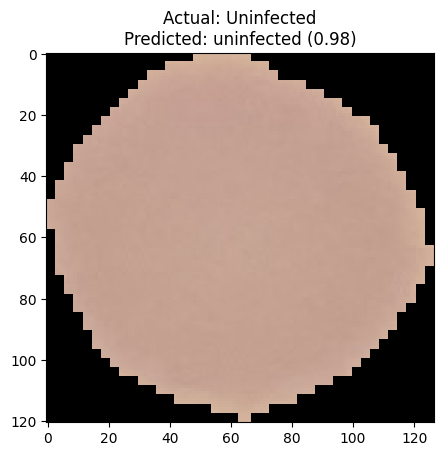


--- PyTorch Port Script Finished ---


In [13]:
# --- Prediction Inference on Random Test Images (like the final Keras cell) ---
print("\n--- Predicting Random Test Images ---")

# Ensure test directories exist
infected_dir_test = os.path.join(test_path, 'parasitized')
uninfected_dir_test = os.path.join(test_path, 'uninfected')

if not os.path.exists(infected_dir_test) or not os.path.exists(uninfected_dir_test):
    print("Error: Test subdirectories ('parasitized', 'uninfected') not found.")
else:
    try:
        # Randomly select one infected and one uninfected image from TEST set
        infected_images_test = random.sample(os.listdir(infected_dir_test), 1)
        uninfected_images_test = random.sample(os.listdir(uninfected_dir_test), 1)

        print("\nPredicting Infected Sample:")
        for img_name in infected_images_test:
            image_path = os.path.join(infected_dir_test, img_name)
            actual_class = "Infected" # Based on folder name
            probability, predicted_class = predict_single_image(image_path, model, single_image_transform, device, class_indices)

            if probability is not None:
                print(f"Image: {img_name}")
                print(f"Actual Class: {actual_class}")
                print(f"Predicted Probability (positive class): {probability:.4f}")
                print(f"Predicted Class: {predicted_class}")
                try:
                    img_display = Image.open(image_path)
                    plt.imshow(img_display)
                    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class} ({probability:.2f})")
                    plt.show()
                except Exception as e:
                     print(f"Could not display image: {e}")


        print("\nPredicting Uninfected Sample:")
        for img_name in uninfected_images_test:
            image_path = os.path.join(uninfected_dir_test, img_name)
            actual_class = "Uninfected" # Based on folder name
            probability, predicted_class = predict_single_image(image_path, model, single_image_transform, device, class_indices)

            if probability is not None:
                print(f"Image: {img_name}")
                print(f"Actual Class: {actual_class}")
                print(f"Predicted Probability (positive class): {probability:.4f}")
                print(f"Predicted Class: {predicted_class}")
                try:
                    img_display = Image.open(image_path)
                    plt.imshow(img_display)
                    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class} ({probability:.2f})")
                    plt.show()
                except Exception as e:
                    print(f"Could not display image: {e}")

    except ValueError as e:
        print(f"Error selecting random images (maybe not enough images in test folders?): {e}")
    except Exception as e:
        print(f"An error occurred during random image prediction: {e}")

print("\n--- PyTorch Port Script Finished ---")

complete inference code to use just with the saved model weights

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Using device: cuda
Loading model from: malaria_detector_pytorch_best.pth
Model loaded successfully.

Selected images for prediction:
- Parasitized: C136P97ThinF_IMG_20151005_140538_cell_120.png
- Uninfected: C64P25N_ThinF_IMG_20150818_152455_cell_96.png

--- Performing Inference ---


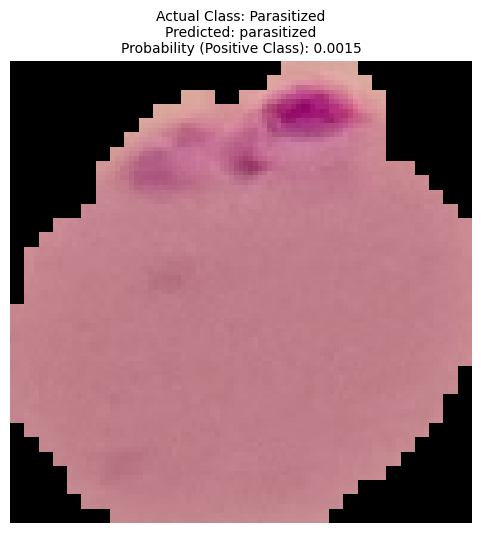


--- Image: C136P97ThinF_IMG_20151005_140538_cell_120.png ---
Actual Class:      Parasitized
Predicted Class:   parasitized
Predicted Prob:    0.0015


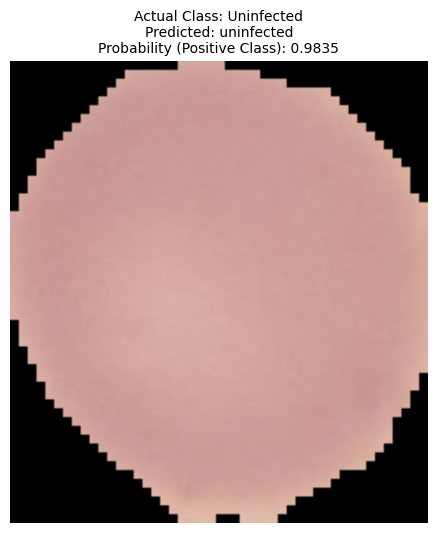


--- Image: C64P25N_ThinF_IMG_20150818_152455_cell_96.png ---
Actual Class:      Uninfected
Predicted Class:   uninfected
Predicted Prob:    0.9835

--- Inference Script Finished ---


In [15]:
# -*- coding: utf-8 -*-
# Import necessary libraries
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms

# --- Try connecting to Google Drive ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # *** Adjust these paths to match your Google Drive structure ***
    gdrive_base_dir = '/content/drive/My Drive/dl-udemy'
    model_path = os.path.join(gdrive_base_dir, 'pytorch_models', 'malaria_detector_pytorch_best.pth')
    test_image_dir = os.path.join(gdrive_base_dir, 'cell_images', 'test')
    print("Google Drive mounted successfully.")
except ModuleNotFoundError:
    print("Not running in Google Colab or Drive mount failed.")
    print("Please ensure the script can access the model and image files.")
    # Set local paths if not in Colab (adjust as needed)
    model_path = './pytorch_models/malaria_detector_pytorch_best.pth' # Example local path
    test_image_dir = './cell_images/test' # Example local path
    # exit() # Optional: exit if not in Colab and paths aren't set
# remove this following line to use the complete inference, next line is colab right after traning only
model_path = 'malaria_detector_pytorch_best.pth' # Example local path
# --- Configuration ---
IMAGE_HEIGHT = 130
IMAGE_WIDTH = 130
# Define the transformations used during testing/evaluation (must match training)
# Typically includes Resize and ToTensor (which also scales to [0, 1])
inference_transforms = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    # Add normalization here ONLY if it was used during training the saved model
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Example normalization
])

# --- Define the Model Architecture (Must be EXACTLY the same as during training) ---
class SimpleCNN(nn.Module):
    def __init__(self, input_shape=(3, IMAGE_HEIGHT, IMAGE_WIDTH)): # Use default shape
        super(SimpleCNN, self).__init__()
        C, H, W = input_shape
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=C, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Calculate flattened size dynamically (important for loading weights)
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.conv_layers(dummy_input)
            self.flattened_size = int(torch.flatten(dummy_output, 1).shape[1])

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout is automatically disabled in model.eval()
            nn.Linear(128, 1) # Output is 1 logit for binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Model ---
print(f"Loading model from: {model_path}")
# Instantiate the model structure
model = SimpleCNN(input_shape=(3, IMAGE_HEIGHT, IMAGE_WIDTH))

# Load the saved weights (state_dict)
try:
    model.load_state_dict(torch.load(model_path, map_location=device)) # map_location ensures correct device loading
    model.to(device) # Move model to the selected device
    model.eval() # Set model to evaluation mode (important!)
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}. Cannot perform inference.")
    exit()
except Exception as e:
    print(f"Error loading model state_dict: {e}")
    print("Ensure the SimpleCNN class definition matches the architecture of the saved model.")
    exit()

# --- Define Class Names (Based on folder structure or training setup) ---
# IMPORTANT: Ensure this matches the indices used during training
# Usually ImageFolder assigns alphabetical order: {'parasitized': 0, 'uninfected': 1} or vice versa
# Check your training output or dataset.class_to_idx if unsure.
class_indices = {'parasitized': 0, 'uninfected': 1} # Adjust if your indices were different
index_to_class = {v: k for k, v in class_indices.items()} # For easy lookup
positive_class_index = 1 # Assuming 'uninfected' is the positive class (output > 0.5). Adjust if 'parasitized' is positive.


# --- Image Selection ---
parasitized_dir = os.path.join(test_image_dir, 'parasitized')
uninfected_dir = os.path.join(test_image_dir, 'uninfected')

try:
    parasitized_images = [os.path.join(parasitized_dir, f) for f in os.listdir(parasitized_dir) if os.path.isfile(os.path.join(parasitized_dir, f))]
    uninfected_images = [os.path.join(uninfected_dir, f) for f in os.listdir(uninfected_dir) if os.path.isfile(os.path.join(uninfected_dir, f))]

    if not parasitized_images or not uninfected_images:
        print("Error: Could not find images in 'parasitized' or 'uninfected' test directories.")
        exit()

    selected_parasitized_img_path = random.choice(parasitized_images)
    selected_uninfected_img_path = random.choice(uninfected_images)

    images_to_predict = {
        "Parasitized": selected_parasitized_img_path,
        "Uninfected": selected_uninfected_img_path
    }
    print("\nSelected images for prediction:")
    print(f"- Parasitized: {os.path.basename(selected_parasitized_img_path)}")
    print(f"- Uninfected: {os.path.basename(selected_uninfected_img_path)}")

except FileNotFoundError:
    print(f"Error: Test image directory or subdirectories not found at {test_image_dir}")
    exit()
except Exception as e:
    print(f"Error listing or selecting images: {e}")
    exit()

# --- Prediction and Display Function ---
def predict_and_display(image_path, actual_class_name, model, transform, device, index_to_class_map, positive_class_idx):
    """Loads, predicts, and displays a single image with annotations."""
    try:
        # Load and transform the image
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device) # Add batch dim and send to device

        # Perform prediction
        with torch.no_grad(): # Disable gradient calculation for inference
            output_logits = model(img_tensor)
            # Apply sigmoid to get probability for the positive class
            probability = torch.sigmoid(output_logits).item()

        # Determine predicted class
        # Assumes output > 0.5 corresponds to the positive class index
        if probability > 0.5:
             predicted_class_index = positive_class_idx
        else:
             predicted_class_index = 1 - positive_class_idx # The other class index

        predicted_class_name = index_to_class_map.get(predicted_class_index, "Unknown")

        # Display results
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Actual Class: {actual_class_name}\n"
                  f"Predicted: {predicted_class_name}\n"
                  f"Probability (Positive Class): {probability:.4f}",
                  fontsize=10)
        plt.axis('off')
        plt.show()

        print(f"\n--- Image: {os.path.basename(image_path)} ---")
        print(f"Actual Class:      {actual_class_name}")
        print(f"Predicted Class:   {predicted_class_name}")
        print(f"Predicted Prob:    {probability:.4f}") # Probability of the positive class

    except FileNotFoundError:
        print(f"Error: Cannot find image file at {image_path}")
    except Exception as e:
        print(f"Error processing or predicting image {os.path.basename(image_path)}: {e}")

# --- Perform Inference on Selected Images ---
print("\n--- Performing Inference ---")
for actual_class, img_path in images_to_predict.items():
     predict_and_display(
         image_path=img_path,
         actual_class_name=actual_class,
         model=model,
         transform=inference_transforms,
         device=device,
         index_to_class_map=index_to_class,
         positive_class_idx=positive_class_index # Make sure this matches your model's output interpretation
    )

print("\n--- Inference Script Finished ---")

save the model in google drive

In [16]:
torch.save(model.state_dict(), '/content/drive/My Drive/dl-udemy/models/malaria_detector_pytorch_final.pth')

download the model

In [14]:
# --- Optional: Download the PyTorch model file (if in Colab) ---
try:
  from google.colab import files
  files.download('malaria_detector_pytorch_best.pth')
except ModuleNotFoundError:
     print("Not in Colab environment, skipping model download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

well done!